This notebook plots the reconstruction error vs. beam intensity for the three distributions: KV, Gaussian, and Danilov.

In [1]:
import sys
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt, animation
from matplotlib.lines import Line2D
import proplot as plot
import seaborn as sns

sys.path.append('/Users/46h/Research/code/accphys/')
from tools import envelope_analysis as ea
from tools import plotting as myplt
from tools import animation as myanim
from tools.utils import list_files

sys.path.append('/Users/46h/Research/code/accphys/pyorbit_studies/measurement/')
from data_analysis import to_vec, to_mat, reconstruct_moments

In [2]:
plot.rc['figure.facecolor'] = 'white'
plot.rc['cycle'] = 'default'
plot.rc['savefig.dpi'] = 'figure'
plot.rc['animation.html'] = 'jshtml'

## Load data 

In [3]:
phases = np.load('_output/data/phases.npy')
intensities = np.load('_output/data/intensities.npy')
ws_positions = np.loadtxt('_output/data/ws_positions.dat')

In [4]:
bunch_kinds = ['danilov', 'kv', 'gaussian']
Sigma0, X0, I_scan_M, I_scan_moments = {}, {}, {}, {}
for kind in bunch_kinds:
    Sigma0[kind] = 1e6 * np.load('_output/data/{}/Sigma0.npy'.format(kind))
    X0[kind] = 1e3 * np.load('_output/data/{}/X0.npy'.format(kind))
    I_scan_M[kind] = np.load('_output/data/{}/I_scan_M.npy'.format(kind))
    I_scan_moments[kind] = 1e6 * np.load('_output/data/{}/I_scan_moments.npy'.format(kind))

## Reconstruction

In [5]:
def reconstruct(transfer_mats, moments):
    A, b = [], []
    for M, (x2, y2, xy) in zip(transfer_mats, moments):
        A.append([M[0, 0]**2, M[0, 1]**2, 2*M[0, 0]*M[0, 1], 0, 0, 0, 0, 0, 0, 0])
        A.append([0, 0, 0, M[2, 2]**2, M[2, 3]**2, 2*M[2, 2]*M[2, 3], 0, 0, 0, 0])
        A.append([0, 0, 0, 0, 0, 0, M[0, 0]*M[2, 2],  M[0, 1]*M[2, 2],  M[0, 0]*M[2, 3],  M[0, 1]*M[2, 3]])
        b.append(x2)
        b.append(y2)
        b.append(xy)
    A, b = np.array(A), np.array(b)
    Sigma = reconstruct_moments(A, b)
    return Sigma

In [6]:
I_Sigma, I_intrinsic_emittances, I_apparent_emittances = {}, {}, {}
for kind in bunch_kinds:
    I_Sigma[kind] = []
    for i in range(len(intensities)):
        transfer_mats = I_scan_M[kind][i]
        moments = I_scan_moments[kind][i]
        Sigma = reconstruct(transfer_mats, moments)
        I_Sigma[kind].append(Sigma)
    I_Sigma[kind] = np.array(I_Sigma[kind])
    I_intrinsic_emittances[kind] = [ea.intrinsic_emittances(Sigma) for Sigma in I_Sigma[kind]]
    I_apparent_emittances[kind] = [ea.apparent_emittances(Sigma) for Sigma in I_Sigma[kind]]

## Analysis 

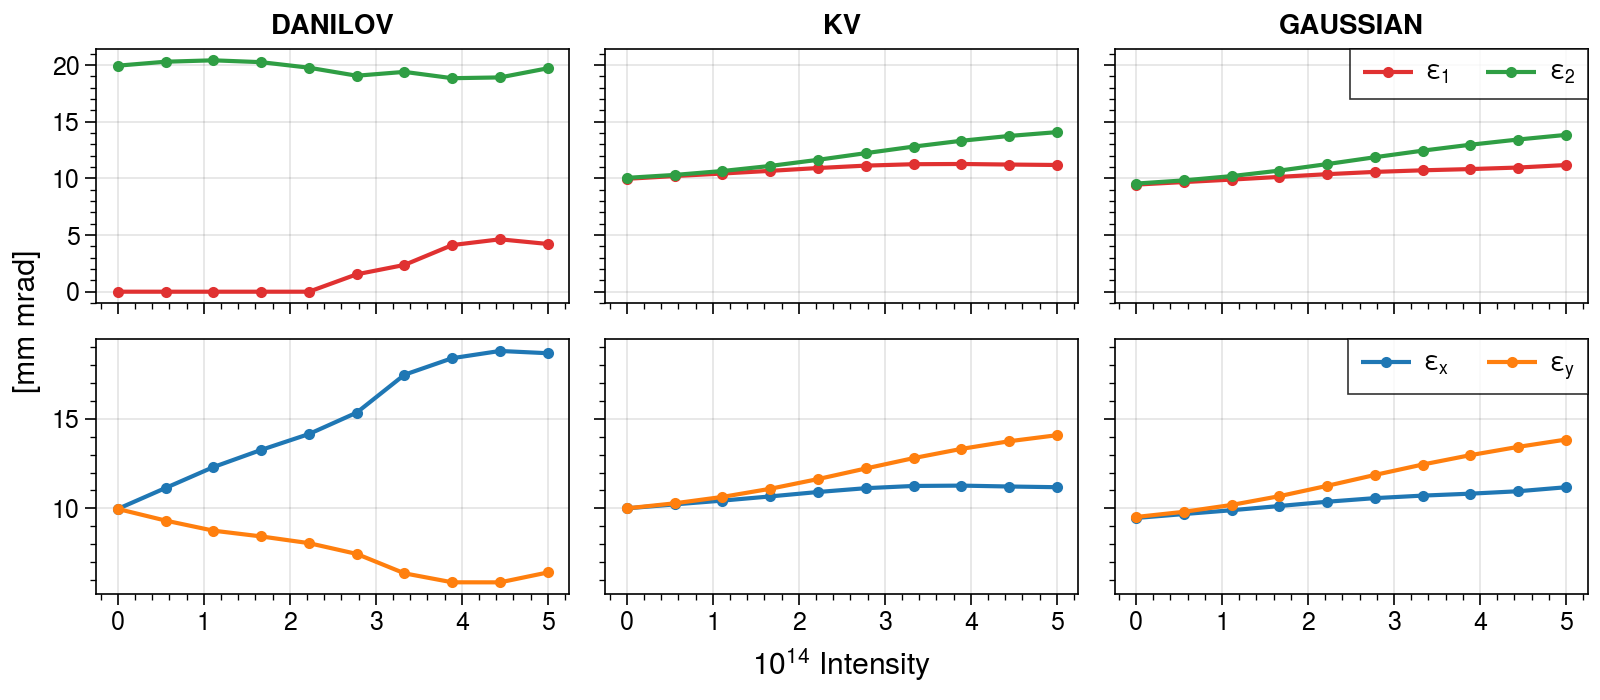

In [9]:
fig, axes = plot.subplots(nrows=2, ncols=3, figsize=(8, 3.5))
for ax, kind in zip(axes[0, :], bunch_kinds):
    ax.plot(intensities/(1e14), I_intrinsic_emittances[kind], marker='.', cycle=('red8', 'green8'))
for ax, kind in zip(axes[1, :], bunch_kinds):
    ax.plot(intensities/(1e14), I_apparent_emittances[kind], marker='.')
axes.format(xlabel=r'$10^{14}$ Intensity',  ylabel='[mm mrad]', 
            toplabels=[kind.upper() for kind in bunch_kinds], 
            xlabel_kw={'size':'large'}, ylabel_kw={'size':'large'})
axes[0, -1].legend(labels=[r'$\varepsilon_1$', r'$\varepsilon_2$']);
axes[1, -1].legend(labels=[r'$\varepsilon_x$', r'$\varepsilon_y$']);
plt.savefig('_output/figures/emittance_vs_intensity.png', facecolor='white', dpi=300)

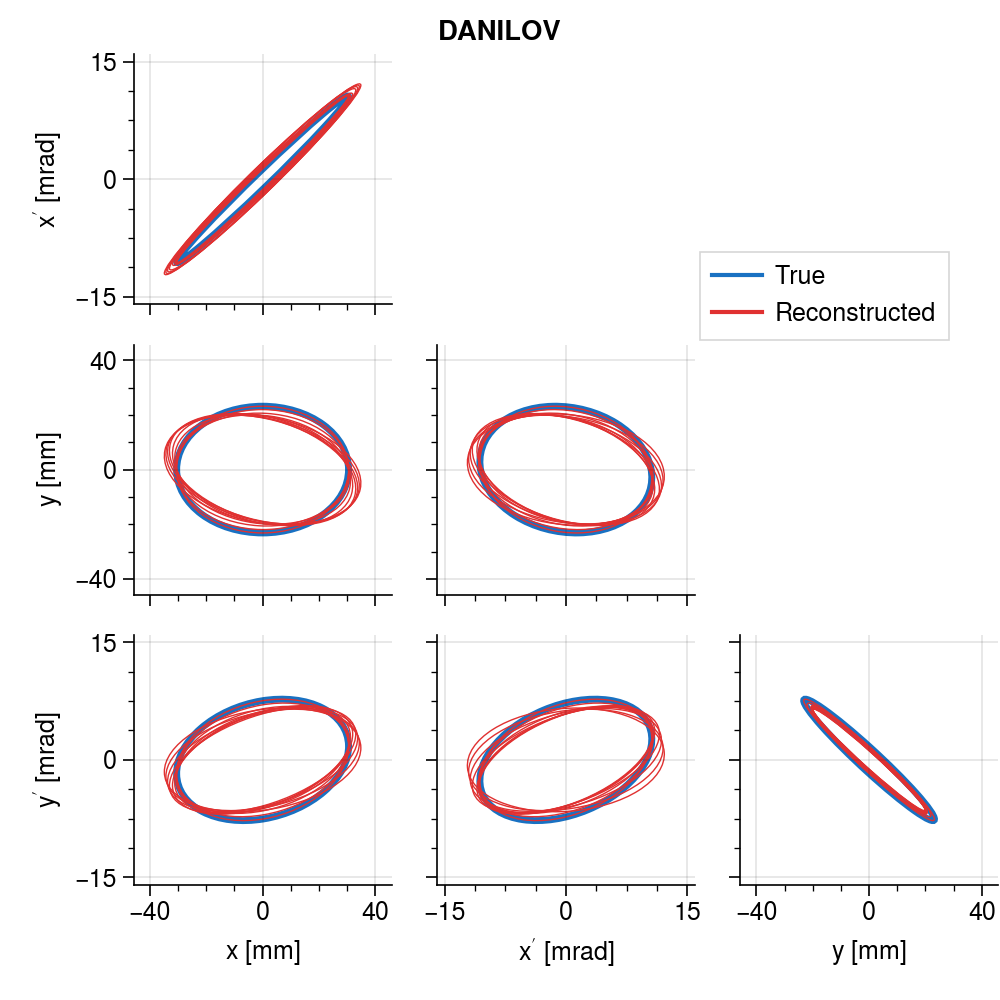

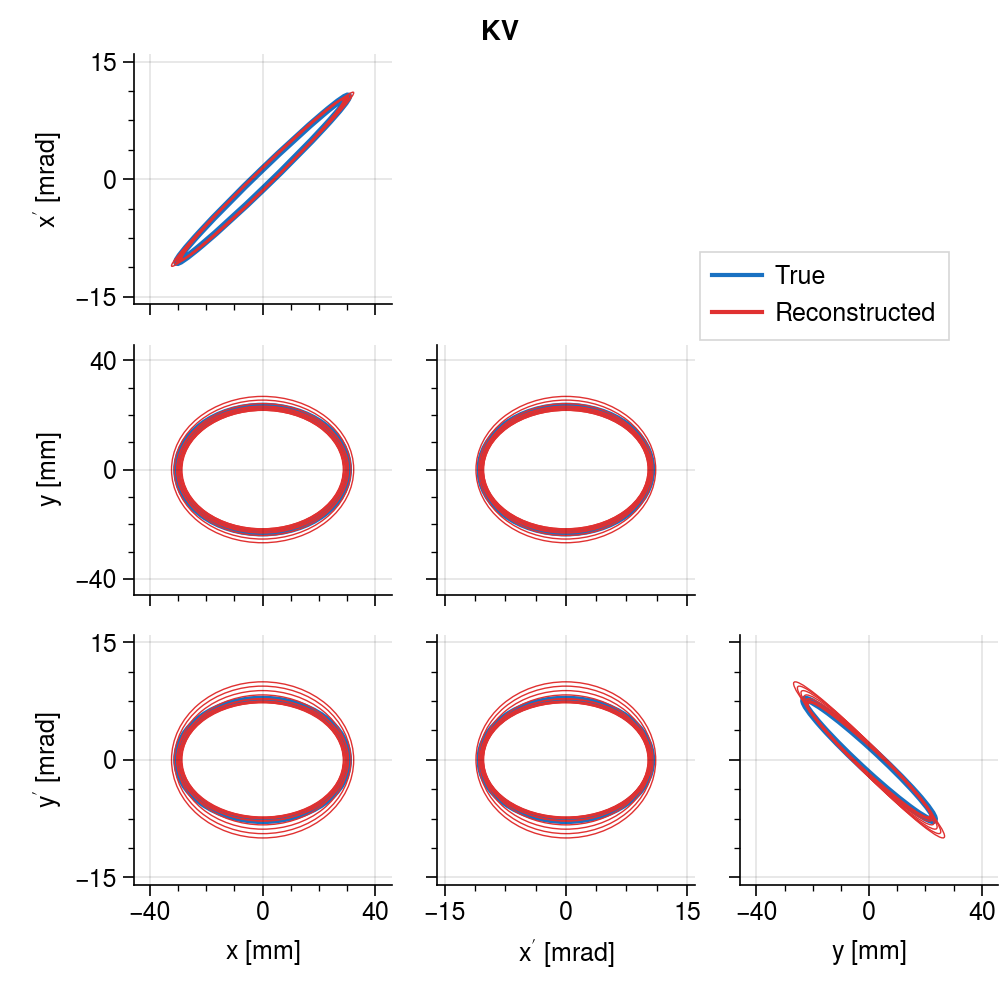

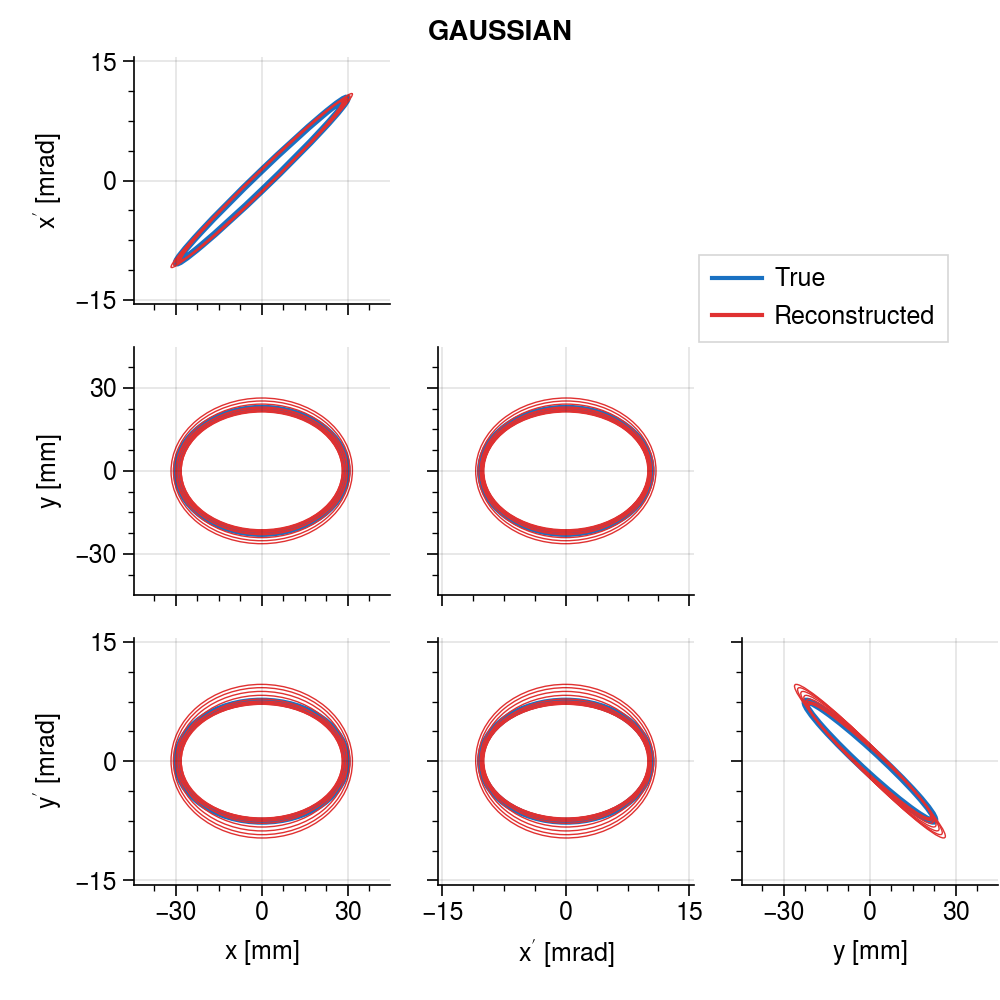

In [24]:
for kind in bunch_kinds:
    axes = myplt.rms_ellipses(Sigma0[kind], color='blue8', lw=2.5, zorder=0);
    for Sigma in I_Sigma[kind]:
        myplt.rms_ellipses(Sigma, axes=axes, color='red8', lw=0.5);
    handles = [Line2D([0], [0], color='blue8'), Line2D([0], [0], color='red8')]
    axes[1, 1].legend(handles, ['True', 'Reconstructed'], loc=(1.02, 1.02));
    plt.suptitle(kind.upper())
    plt.savefig('_output/figures/corner_{}.png'.format(kind), facecolor='white', dpi=250)